##📘 O que é LSTM e por que foi usada aqui?

Neste projeto, usamos um tipo de **inteligência artificial** chamada **rede neural LSTM (Long Short-Term Memory)** para tentar prever os valores futuros de arrecadação com base nos valores passados.

Esse tipo de rede é muito bom para lidar com **informações que acontecem em sequência**, como uma linha do tempo. Imagine que você consegue entender uma música porque lembra das notas anteriores — a LSTM funciona de forma parecida: ela tenta “lembrar” dos meses anteriores para prever os próximos.

Ao invés de olhar só o valor de um mês isolado, a LSTM aprende os **padrões e comportamentos da arrecadação** ao longo do tempo: se costuma subir, cair, repetir em certas épocas do ano, entre outros.

Ela foi escolhida neste projeto justamente porque consegue usar o **histórico para fazer previsões** mais próximas da realidade. A ideia é ajudar a ter uma **visão antecipada** dos próximos meses, o que pode ser útil para planejamento e tomada de decisões.



# Importar dados do Excel

Realiza a leitura e importação dos dados da planilha.

In [1]:
import pandas as pd

dadosPrev = pd.read_excel("dadosPrev.xlsx")
dadosPrev.set_index("Mês", inplace=True)
dadosPrev = dadosPrev.dropna()
dadosPrev.head()



,Valor
Mês,
1998-01-01,83756020.0
1998-02-01,82131307.0
1998-03-01,69267693.0
1998-04-01,81286029.0
1998-05-01,87060196.0


# Visualização da série temporal

Realiza a plotagem dos dados através do MatPlotLib.

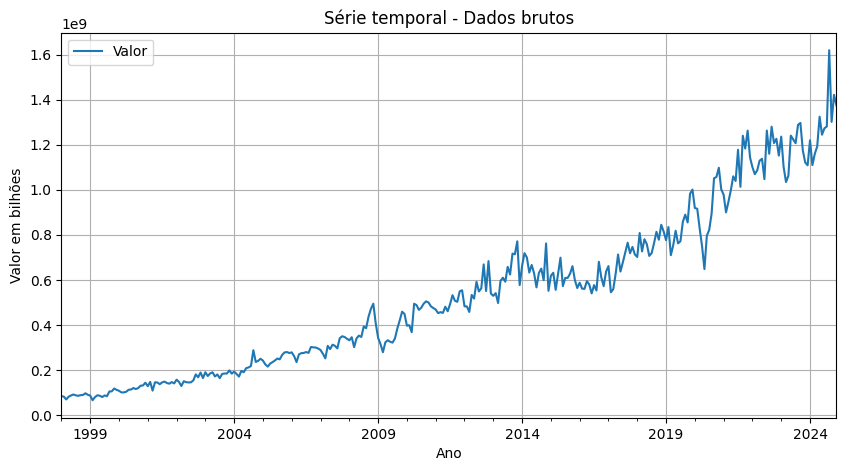

In [2]:
import matplotlib.pyplot as plt

dadosPrev.plot(figsize=(10,5), title="Série temporal - Dados brutos")
plt.xlabel("Ano")
plt.ylabel("Valor em bilhões")
plt.grid(True)
plt.show()

# Pré-Processamento

Preparação dos dados contidos na planilha para visualização dos primeiros 12 meses para prever o 13°.

In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled = scaler.fit_transform(dadosPrev[["Valor"]])

def criar_janelas(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 12
X, y = criar_janelas(scaled, n_steps)

X.shape

(312, 12, 1)

# Construção do LSTM

Construção do modelo de ML LSTM para processamento dos dados.

In [30]:
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

model = Sequential()
model.add(GRU(64, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(32, activation='tanh', return_sequences=False))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, 'linear'))

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=Huber(delta=1.0)
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 12, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,825 (100.88 KB)

 Trainable params: 25,825 (100.88 KB)

 Non-trainable params: 0 (0.00 B)

# Treinamento do Modelo

Aplicação do treinamento do modelo por épocas.

In [31]:
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'melhor_modelo.h5',
    monitor='loss',
    save_best_only=True,
    mode='min',
    verbose=0
)

class ColorLossFeedback(Callback):
    def __init__(self):
        super().__init__()
        self.best_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')
        if current_loss is not None:
            if current_loss < self.best_loss:
                print(f"\033[92mEpoch {epoch+1}: Loss melhorou → {current_loss:.6f}\033[0m")
                self.best_loss = current_loss
            elif current_loss > self.best_loss:
                print(f"\033[91mEpoch {epoch+1}: Loss piorou   → {current_loss:.6f}\033[0m")
            else:
                print(f"\033[90mEpoch {epoch+1}: Loss igual     → {current_loss:.6f}\033[0m")


model.fit(X, y, epochs=500, verbose=0, callbacks=[ColorLossFeedback(), checkpoint])


Epoch 1: Loss melhorou → 0.038268


Epoch 2: Loss melhorou → 0.006748


Epoch 3: Loss melhorou → 0.003108


Epoch 4: Loss melhorou → 0.001392


Epoch 5: Loss melhorou → 0.001066


Epoch 6: Loss melhorou → 0.000890


Epoch 7: Loss melhorou → 0.000825
Epoch 8: Loss piorou   → 0.000834
Epoch 9: Loss piorou   → 0.000943
Epoch 10: Loss piorou   → 0.000873
Epoch 11: Loss piorou   → 0.000859


Epoch 12: Loss piorou   → 0.000853
Epoch 13: Loss melhorou → 0.000824
Epoch 14: Loss piorou   → 0.000852
Epoch 15: Loss piorou   → 0.000837
Epoch 16: Loss piorou   → 0.000844
Epoch 17: Loss piorou   → 0.000829


Epoch 18: Loss piorou   → 0.000835
Epoch 19: Loss melhorou → 0.000823


Epoch 20: Loss melhorou → 0.000822


Epoch 21: Loss melhorou → 0.000802
Epoch 22: Loss piorou   → 0.000909
Epoch 23: Loss piorou   → 0.000868
Epoch 24: Loss piorou   → 0.000872
Epoch 25: Loss piorou   → 0.000826
Epoch 26: Loss piorou   → 0.000876
Epoch 27: Loss piorou   → 0.000841
Epoch 28: Loss piorou   → 0.000814
Epoch 29: Loss piorou   → 0.000813


Epoch 30: Loss melhorou → 0.000802
Epoch 31: Loss piorou   → 0.000810
Epoch 32: Loss piorou   → 0.000850
Epoch 33: Loss piorou   → 0.000949
Epoch 34: Loss piorou   → 0.000928
Epoch 35: Loss piorou   → 0.000842
Epoch 36: Loss piorou   → 0.000871
Epoch 37: Loss piorou   → 0.000825
Epoch 38: Loss piorou   → 0.000857


Epoch 39: Loss melhorou → 0.000793
Epoch 40: Loss piorou   → 0.000823
Epoch 41: Loss piorou   → 0.000807
Epoch 42: Loss piorou   → 0.000866
Epoch 43: Loss piorou   → 0.000809
Epoch 44: Loss piorou   → 0.000808
Epoch 45: Loss piorou   → 0.000891
Epoch 46: Loss piorou   → 0.000918


Epoch 47: Loss melhorou → 0.000791
Epoch 48: Loss piorou   → 0.000806
Epoch 49: Loss piorou   → 0.000909
Epoch 50: Loss piorou   → 0.000843
Epoch 51: Loss piorou   → 0.000827
Epoch 52: Loss piorou   → 0.000945
Epoch 53: Loss piorou   → 0.000825
Epoch 54: Loss piorou   → 0.000825
Epoch 55: Loss piorou   → 0.000847
Epoch 56: Loss piorou   → 0.000840
Epoch 57: Loss piorou   → 0.000806


Epoch 58: Loss piorou   → 0.000808
Epoch 59: Loss melhorou → 0.000767
Epoch 60: Loss piorou   → 0.000808
Epoch 61: Loss piorou   → 0.000797
Epoch 62: Loss piorou   → 0.000843
Epoch 63: Loss piorou   → 0.000914
Epoch 64: Loss piorou   → 0.000879
Epoch 65: Loss piorou   → 0.000811
Epoch 66: Loss piorou   → 0.000775


Epoch 67: Loss piorou   → 0.000770
Epoch 68: Loss melhorou → 0.000748
Epoch 69: Loss piorou   → 0.000749
Epoch 70: Loss piorou   → 0.000784
Epoch 71: Loss piorou   → 0.000765
Epoch 72: Loss piorou   → 0.000758
Epoch 73: Loss piorou   → 0.000760
Epoch 74: Loss piorou   → 0.000850
Epoch 75: Loss piorou   → 0.000818
Epoch 76: Loss piorou   → 0.000906
Epoch 77: Loss piorou   → 0.000766
Epoch 78: Loss piorou   → 0.000839
Epoch 79: Loss piorou   → 0.000801
Epoch 80: Loss piorou   → 0.000838
Epoch 81: Loss piorou   → 0.000815
Epoch 82: Loss piorou   → 0.000840
Epoch 83: Loss piorou   → 0.000951
Epoch 84: Loss piorou   → 0.000851
Epoch 85: Loss piorou   → 0.000885
Epoch 86: Loss piorou   → 0.000810


Epoch 87: Loss piorou   → 0.000750
Epoch 88: Loss melhorou → 0.000725
Epoch 89: Loss piorou   → 0.000762
Epoch 90: Loss piorou   → 0.000779
Epoch 91: Loss piorou   → 0.000855
Epoch 92: Loss piorou   → 0.000897
Epoch 93: Loss piorou   → 0.000758
Epoch 94: Loss piorou   → 0.000841
Epoch 95: Loss piorou   → 0.000831
Epoch 96: Loss piorou   → 0.000769


Epoch 97: Loss melhorou → 0.000711
Epoch 98: Loss piorou   → 0.000736
Epoch 99: Loss piorou   → 0.000829
Epoch 100: Loss piorou   → 0.000773
Epoch 101: Loss piorou   → 0.000773
Epoch 102: Loss piorou   → 0.000770
Epoch 103: Loss piorou   → 0.000801
Epoch 104: Loss piorou   → 0.000729
Epoch 105: Loss piorou   → 0.000733
Epoch 106: Loss piorou   → 0.000757
Epoch 107: Loss piorou   → 0.000772
Epoch 108: Loss piorou   → 0.000721


Epoch 109: Loss melhorou → 0.000700
Epoch 110: Loss piorou   → 0.000702


Epoch 111: Loss melhorou → 0.000689
Epoch 112: Loss piorou   → 0.000694
Epoch 113: Loss piorou   → 0.000701
Epoch 114: Loss piorou   → 0.000730
Epoch 115: Loss piorou   → 0.000729


Epoch 116: Loss melhorou → 0.000677
Epoch 117: Loss piorou   → 0.000692
Epoch 118: Loss piorou   → 0.000704
Epoch 119: Loss piorou   → 0.000765
Epoch 120: Loss piorou   → 0.000710
Epoch 121: Loss piorou   → 0.000681
Epoch 122: Loss piorou   → 0.000678
Epoch 123: Loss piorou   → 0.000734
Epoch 124: Loss piorou   → 0.000697
Epoch 125: Loss piorou   → 0.000690
Epoch 126: Loss piorou   → 0.000711
Epoch 127: Loss piorou   → 0.000707
Epoch 128: Loss piorou   → 0.000680
Epoch 129: Loss piorou   → 0.000691
Epoch 130: Loss piorou   → 0.000697


Epoch 131: Loss melhorou → 0.000659
Epoch 132: Loss piorou   → 0.000700


Epoch 133: Loss melhorou → 0.000654
Epoch 134: Loss piorou   → 0.000667
Epoch 135: Loss piorou   → 0.000690


Epoch 136: Loss melhorou → 0.000646
Epoch 137: Loss piorou   → 0.000648
Epoch 138: Loss piorou   → 0.000655
Epoch 139: Loss piorou   → 0.000651


Epoch 140: Loss melhorou → 0.000646
Epoch 141: Loss piorou   → 0.000664
Epoch 142: Loss piorou   → 0.000650


Epoch 143: Loss melhorou → 0.000637
Epoch 144: Loss piorou   → 0.000696
Epoch 145: Loss piorou   → 0.000664
Epoch 146: Loss piorou   → 0.000643
Epoch 147: Loss piorou   → 0.000703
Epoch 148: Loss piorou   → 0.000749
Epoch 149: Loss piorou   → 0.000639
Epoch 150: Loss piorou   → 0.000817
Epoch 151: Loss piorou   → 0.000673
Epoch 152: Loss piorou   → 0.000675
Epoch 153: Loss piorou   → 0.000676
Epoch 154: Loss piorou   → 0.000686
Epoch 155: Loss piorou   → 0.000741
Epoch 156: Loss piorou   → 0.000903
Epoch 157: Loss piorou   → 0.000768
Epoch 158: Loss piorou   → 0.000801
Epoch 159: Loss piorou   → 0.000694


Epoch 160: Loss melhorou → 0.000619
Epoch 161: Loss piorou   → 0.000686
Epoch 162: Loss piorou   → 0.000756
Epoch 163: Loss piorou   → 0.000647
Epoch 164: Loss piorou   → 0.000665
Epoch 165: Loss piorou   → 0.000699
Epoch 166: Loss piorou   → 0.000651
Epoch 167: Loss piorou   → 0.000648
Epoch 168: Loss piorou   → 0.000692
Epoch 169: Loss piorou   → 0.000706
Epoch 170: Loss piorou   → 0.000637
Epoch 171: Loss piorou   → 0.000693


Epoch 172: Loss melhorou → 0.000615


Epoch 173: Loss melhorou → 0.000609
Epoch 174: Loss piorou   → 0.000623


Epoch 175: Loss melhorou → 0.000588
Epoch 176: Loss piorou   → 0.000651
Epoch 177: Loss piorou   → 0.000603
Epoch 178: Loss piorou   → 0.000716
Epoch 179: Loss piorou   → 0.000589
Epoch 180: Loss piorou   → 0.000600
Epoch 181: Loss piorou   → 0.000594


Epoch 182: Loss melhorou → 0.000588
Epoch 183: Loss piorou   → 0.000605
Epoch 184: Loss piorou   → 0.000658
Epoch 185: Loss piorou   → 0.000785
Epoch 186: Loss piorou   → 0.000629


Epoch 187: Loss melhorou → 0.000573
Epoch 188: Loss piorou   → 0.000619
Epoch 189: Loss piorou   → 0.000615
Epoch 190: Loss piorou   → 0.000608
Epoch 191: Loss piorou   → 0.000613
Epoch 192: Loss piorou   → 0.000719
Epoch 193: Loss piorou   → 0.000638
Epoch 194: Loss piorou   → 0.000625
Epoch 195: Loss piorou   → 0.000630
Epoch 196: Loss piorou   → 0.000594
Epoch 197: Loss piorou   → 0.000606
Epoch 198: Loss piorou   → 0.000581
Epoch 199: Loss piorou   → 0.000639
Epoch 200: Loss piorou   → 0.000621
Epoch 201: Loss piorou   → 0.000591
Epoch 202: Loss piorou   → 0.000583
Epoch 203: Loss piorou   → 0.000586
Epoch 204: Loss piorou   → 0.000578
Epoch 205: Loss piorou   → 0.000603
Epoch 206: Loss piorou   → 0.000680
Epoch 207: Loss piorou   → 0.000686
Epoch 208: Loss piorou   → 0.000617
Epoch 209: Loss piorou   → 0.000576
Epoch 210: Loss piorou   → 0.000616
Epoch 211: Loss piorou   → 0.000625
Epoch 212: Loss piorou   → 0.000575
Epoch 213: Loss piorou   → 0.000620
Epoch 214: Loss piorou   → 0

Epoch 234: Loss piorou   → 0.000584
Epoch 235: Loss melhorou → 0.000573


Epoch 236: Loss melhorou → 0.000573
Epoch 237: Loss piorou   → 0.000574
Epoch 238: Loss piorou   → 0.000582
Epoch 239: Loss piorou   → 0.000574
Epoch 240: Loss piorou   → 0.000651
Epoch 241: Loss piorou   → 0.000668
Epoch 242: Loss piorou   → 0.000640
Epoch 243: Loss piorou   → 0.000624
Epoch 244: Loss piorou   → 0.000611
Epoch 245: Loss piorou   → 0.000577
Epoch 246: Loss piorou   → 0.000595
Epoch 247: Loss piorou   → 0.000599
Epoch 248: Loss piorou   → 0.000597
Epoch 249: Loss piorou   → 0.000627
Epoch 250: Loss piorou   → 0.000701
Epoch 251: Loss piorou   → 0.000672
Epoch 252: Loss piorou   → 0.000628
Epoch 253: Loss piorou   → 0.000583
Epoch 254: Loss piorou   → 0.000596
Epoch 255: Loss piorou   → 0.000596
Epoch 256: Loss piorou   → 0.000610
Epoch 257: Loss piorou   → 0.000648
Epoch 258: Loss piorou   → 0.000634
Epoch 259: Loss piorou   → 0.000606
Epoch 260: Loss piorou   → 0.000588
Epoch 261: Loss piorou   → 0.000592
Epoch 262: Loss piorou   → 0.000580
Epoch 263: Loss piorou   → 0

Epoch 266: Loss piorou   → 0.000583
Epoch 267: Loss melhorou → 0.000570
Epoch 268: Loss piorou   → 0.000611
Epoch 269: Loss piorou   → 0.000598
Epoch 270: Loss piorou   → 0.000585
Epoch 271: Loss piorou   → 0.000574
Epoch 272: Loss piorou   → 0.000579


Epoch 273: Loss melhorou → 0.000565
Epoch 274: Loss piorou   → 0.000602
Epoch 275: Loss piorou   → 0.000593
Epoch 276: Loss piorou   → 0.000575
Epoch 277: Loss piorou   → 0.000592
Epoch 278: Loss piorou   → 0.000588
Epoch 279: Loss piorou   → 0.000583
Epoch 280: Loss piorou   → 0.000617
Epoch 281: Loss piorou   → 0.000649
Epoch 282: Loss piorou   → 0.000635
Epoch 283: Loss piorou   → 0.000657
Epoch 284: Loss piorou   → 0.000612
Epoch 285: Loss piorou   → 0.000610
Epoch 286: Loss piorou   → 0.000613


Epoch 287: Loss piorou   → 0.000574
Epoch 288: Loss melhorou → 0.000561
Epoch 289: Loss piorou   → 0.000606
Epoch 290: Loss piorou   → 0.000579
Epoch 291: Loss piorou   → 0.000581
Epoch 292: Loss piorou   → 0.000623
Epoch 293: Loss piorou   → 0.000601
Epoch 294: Loss piorou   → 0.000692
Epoch 295: Loss piorou   → 0.000647
Epoch 296: Loss piorou   → 0.000589
Epoch 297: Loss piorou   → 0.000630
Epoch 298: Loss piorou   → 0.000657
Epoch 299: Loss piorou   → 0.000588
Epoch 300: Loss piorou   → 0.000607
Epoch 301: Loss piorou   → 0.000608
Epoch 302: Loss piorou   → 0.000598
Epoch 303: Loss piorou   → 0.000618
Epoch 304: Loss piorou   → 0.000578
Epoch 305: Loss piorou   → 0.000617
Epoch 306: Loss piorou   → 0.000587
Epoch 307: Loss piorou   → 0.000586
Epoch 308: Loss piorou   → 0.000565
Epoch 309: Loss piorou   → 0.000564
Epoch 310: Loss piorou   → 0.000601
Epoch 311: Loss piorou   → 0.000591
Epoch 312: Loss piorou   → 0.000576
Epoch 313: Loss piorou   → 0.000578
Epoch 314: Loss piorou   → 0

Epoch 415: Loss melhorou → 0.000558
Epoch 416: Loss piorou   → 0.000575
Epoch 417: Loss piorou   → 0.000655
Epoch 418: Loss piorou   → 0.000605


Epoch 419: Loss piorou   → 0.000597
Epoch 420: Loss melhorou → 0.000556
Epoch 421: Loss piorou   → 0.000559
Epoch 422: Loss piorou   → 0.000562
Epoch 423: Loss piorou   → 0.000586
Epoch 424: Loss piorou   → 0.000618
Epoch 425: Loss piorou   → 0.000598


Epoch 426: Loss melhorou → 0.000556
Epoch 427: Loss piorou   → 0.000563
Epoch 428: Loss piorou   → 0.000635
Epoch 429: Loss piorou   → 0.000622
Epoch 430: Loss piorou   → 0.000590
Epoch 431: Loss piorou   → 0.000583
Epoch 432: Loss piorou   → 0.000573
Epoch 433: Loss piorou   → 0.000576
Epoch 434: Loss piorou   → 0.000573
Epoch 435: Loss piorou   → 0.000585
Epoch 436: Loss piorou   → 0.000573
Epoch 437: Loss piorou   → 0.000559
Epoch 438: Loss piorou   → 0.000582
Epoch 439: Loss piorou   → 0.000557
Epoch 440: Loss piorou   → 0.000594
Epoch 441: Loss piorou   → 0.000573
Epoch 442: Loss piorou   → 0.000600
Epoch 443: Loss piorou   → 0.000597
Epoch 444: Loss piorou   → 0.000578


Epoch 445: Loss melhorou → 0.000554
Epoch 446: Loss piorou   → 0.000582
Epoch 447: Loss piorou   → 0.000576
Epoch 448: Loss piorou   → 0.000572
Epoch 449: Loss piorou   → 0.000585
Epoch 450: Loss piorou   → 0.000575
Epoch 451: Loss piorou   → 0.000603
Epoch 452: Loss piorou   → 0.000581
Epoch 453: Loss piorou   → 0.000617
Epoch 454: Loss piorou   → 0.000613
Epoch 455: Loss piorou   → 0.000682
Epoch 456: Loss piorou   → 0.000592
Epoch 457: Loss piorou   → 0.000588
Epoch 458: Loss piorou   → 0.000573
Epoch 459: Loss piorou   → 0.000563
Epoch 460: Loss piorou   → 0.000579
Epoch 461: Loss piorou   → 0.000686
Epoch 462: Loss piorou   → 0.000645
Epoch 463: Loss piorou   → 0.000563
Epoch 464: Loss piorou   → 0.000703
Epoch 465: Loss piorou   → 0.000586
Epoch 466: Loss piorou   → 0.000608
Epoch 467: Loss piorou   → 0.000560
Epoch 468: Loss piorou   → 0.000559
Epoch 469: Loss piorou   → 0.000555
Epoch 470: Loss piorou   → 0.000569


Epoch 471: Loss melhorou → 0.000543
Epoch 472: Loss piorou   → 0.000588
Epoch 473: Loss piorou   → 0.000578
Epoch 474: Loss piorou   → 0.000560
Epoch 475: Loss piorou   → 0.000550
Epoch 476: Loss piorou   → 0.000571
Epoch 477: Loss piorou   → 0.000591
Epoch 478: Loss piorou   → 0.000581
Epoch 479: Loss piorou   → 0.000562
Epoch 480: Loss piorou   → 0.000566
Epoch 481: Loss piorou   → 0.000595
Epoch 482: Loss piorou   → 0.000588
Epoch 483: Loss piorou   → 0.000586
Epoch 484: Loss piorou   → 0.000570
Epoch 485: Loss piorou   → 0.000575
Epoch 486: Loss piorou   → 0.000562
Epoch 487: Loss piorou   → 0.000565
Epoch 488: Loss piorou   → 0.000576
Epoch 489: Loss piorou   → 0.000547
Epoch 490: Loss piorou   → 0.000558
Epoch 491: Loss piorou   → 0.000561
Epoch 492: Loss piorou   → 0.000552
Epoch 493: Loss piorou   → 0.000571
Epoch 494: Loss piorou   → 0.000558
Epoch 495: Loss piorou   → 0.000588
Epoch 496: Loss piorou   → 0.000558
Epoch 497: Loss piorou   → 0.000558
Epoch 498: Loss piorou   → 0

# Previsões dos próximos meses

Realiza a previsão através da análise dos últimos 12 meses.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


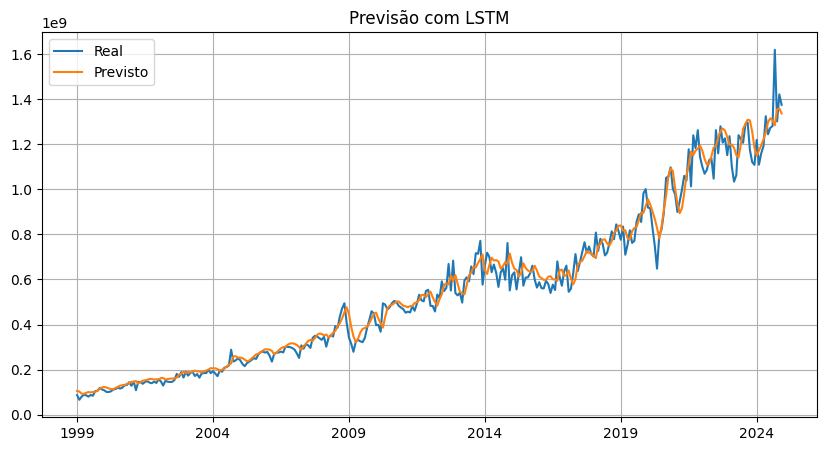

In [35]:
y_pred = model.predict(X)
y_pred = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(y)
plt.figure(figsize=(10,5))
plt.plot(y_true, label="Real")
plt.plot(y_pred, label="Previsto")
plt.legend()
plt.title("Previsão com LSTM")
plt.grid(True)
tick_positions = list(range(0, len(y_true), 60))
tick_labels = ['1999', '2004', '2009', '2014', '2019', '2024']

plt.xticks(ticks=tick_positions, labels=tick_labels)
plt.show()

In [36]:
import pandas as pd

resultados = pd.DataFrame({
    "Real": y_true.flatten(),
    "Previsto": y_pred.flatten(),
    "Diferenca": (y_pred.flatten() - y_true.flatten()),
    "Porcentagem": ((y_pred.flatten() - y_true.flatten()) / y_true.flatten()) * 100
})

resultados.index = dadosPrev.index[n_steps:]


resultados = resultados[(resultados.index.year >= 2019) & (resultados.index.year <= 2024)]


pd.options.display.float_format = '{:,.2f}'.format


pd.set_option('display.max_rows', None)

print(resultados[["Real", "Previsto", "Diferenca", "Porcentagem"]])

                       Real         Previsto       Diferenca  Porcentagem
Mês                                                                      
2019-01-01   776,372,750.67   839,549,824.00   63,177,073.33         8.14
2019-02-01   834,733,603.78   816,630,400.00  -18,103,203.78        -2.17
2019-03-01   709,811,573.65   818,693,632.00  108,882,058.35        15.34
2019-04-01   754,324,310.89   783,378,304.00   29,053,993.11         3.85
2019-05-01   818,233,616.61   776,368,128.00  -41,865,488.61        -5.12
2019-06-01   762,378,747.40   814,606,144.00   52,227,396.60         6.85
2019-07-01   771,578,679.07   828,733,184.00   57,154,504.93         7.41
2019-08-01   857,825,786.88   833,246,976.00  -24,578,810.88        -2.87
2019-09-01   889,796,196.12   865,675,840.00  -24,120,356.12        -2.71
2019-10-01   855,116,796.98   897,098,816.00   41,982,019.02         4.91
2019-11-01   982,278,201.94   895,401,344.00  -86,876,857.94        -8.84
2019-12-01 1,001,139,013.46   926,230,

# Previsão 2025

Aplica o melhor modelo para prever os meses de janeiro à abril de 2025.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


                   Previsão
Data                       
2025-01-01 1,312,830,464.00
2025-02-01 1,279,282,688.00
2025-03-01 1,261,702,272.00
2025-04-01 1,260,111,616.00
2025-05-01 1,275,122,304.00
2025-06-01 1,296,390,912.00
2025-07-01 1,327,668,096.00
2025-08-01 1,357,245,440.00
2025-09-01 1,381,668,352.00
2025-10-01 1,377,005,440.00
2025-11-01 1,377,004,672.00
2025-12-01 1,357,951,360.00


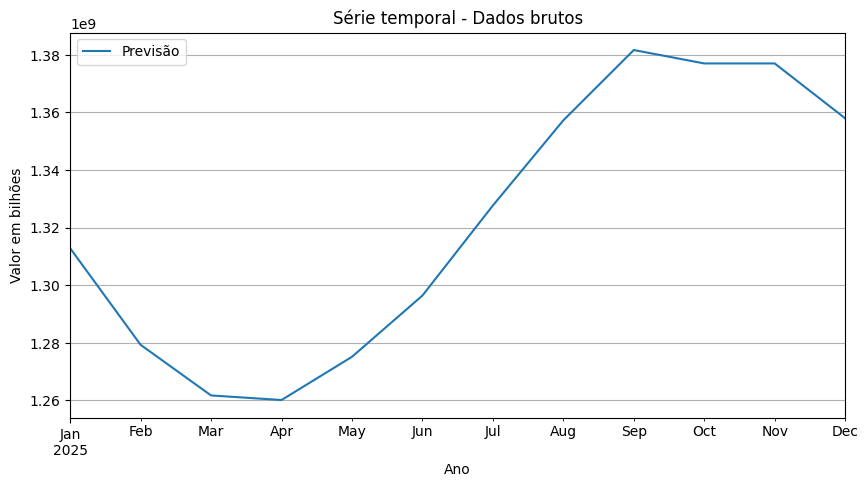

In [34]:
import numpy as np
from tensorflow.keras.models import load_model
import pandas as pd

# 1. Carregar o melhor modelo
melhor_modelo = load_model('melhor_modelo.h5', compile=False)

# 2. Obter os últimos n_steps valores antes de jan/2025
ultimos_dados = dadosPrev['Valor'][-n_steps:].values.reshape(-1, 1)
entrada = scaler.transform(ultimos_dados)

# 3. Prever os 4 próximos meses (jan-abr/2025) iterativamente
previsoes_scaled = []
entrada_seq = entrada.copy()

for _ in range(12):
    x_input = entrada_seq.reshape(1, n_steps, 1)
    y_pred = melhor_modelo.predict(x_input, verbose=0)
    previsoes_scaled.append(y_pred[0][0])

    # Atualiza a sequência: remove o primeiro e adiciona o novo valor previsto
    entrada_seq = np.append(entrada_seq[1:], y_pred, axis=0)

# 4. Inverter a escala para valores reais
previsoes_reais = scaler.inverse_transform(np.array(previsoes_scaled).reshape(-1, 1))

# 5. Criar datas para o índice
datas_previstas = pd.date_range(start='2025-01-01', periods=12, freq='MS')

# 6. Criar DataFrame com as previsões
df_previsao = pd.DataFrame({
    'Data': datas_previstas,
    'Previsão': previsoes_reais.flatten()
})
df_previsao.set_index('Data', inplace=True)

# 7. Mostrar a previsão
print(df_previsao)

df_previsao.plot(figsize=(10,5), title="Série temporal - Dados brutos")
plt.xlabel("Ano")
plt.ylabel("Valor em bilhões")
plt.grid(True)
plt.show()
